In [1]:
import torch
from pytorch3d.loss import chamfer_distance
import trimesh
import os
import pyvista as pv
pv.set_jupyter_backend("ipyvtklink")
import numpy as np
import matplotlib.pyplot as plt

from neutex.neutex import make_neutex_for_pretraining
from utils import to_device

In [2]:
# mesh_path = "../human_and_cat/cat_rescaled_rotated/12221_Cat_v1_l3.obj"
mesh_path = "../human_and_cat/human/RUST_3d_Low1.obj"

out_dir = "pretrained/cat_rescaled_rotated_pretrained_neutex_mapping.pt"

device = "cuda"

mesh = trimesh.load(mesh_path)
mesh_vertices = torch.from_numpy(mesh.vertices).to(device=device, dtype=torch.float32)

iterations = 200000
lr = 1e-4

print_every_iter = 500

model = make_neutex_for_pretraining()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_history = []

In [3]:
model.train()

# Pretraining
for i in range(iterations):
    output = model(None, init_pass=True)

    sampled_uv_points, points3d, inverted_uv_points = output["sampled_uv_points"], output["points3d"], output["inverted_uv_points"]

    # Chamfer Loss
    chamfer_loss, _ = chamfer_distance(mesh_vertices.unsqueeze(0), points3d.unsqueeze(0), point_reduction="mean")
    # 2D-3D-2D Cycle Loss
    cycle_loss = ((sampled_uv_points - inverted_uv_points)**2).sum(axis=-1).mean()
    
    loss = chamfer_loss + cycle_loss
    
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    if i % print_every_iter == 0:
        print(f"Iteration {i+1:7d}/{iterations:7d}  Loss: {loss_history[-1]}   Chamfer Loss: {chamfer_loss.item()}    Cycle Loss: {cycle_loss.item()}")

Iteration       1/ 200000  Loss: 2.3564696311950684   Chamfer Loss: 0.2002539485692978    Cycle Loss: 2.1562156677246094
Iteration     501/ 200000  Loss: 0.001901326235383749   Chamfer Loss: 0.0016272645443677902    Cycle Loss: 0.0002740616910159588
Iteration    1001/ 200000  Loss: 0.001260992605239153   Chamfer Loss: 0.001127648283727467    Cycle Loss: 0.00013334437971934676
Iteration    1501/ 200000  Loss: 0.0009812181815505028   Chamfer Loss: 0.0008761473000049591    Cycle Loss: 0.00010507083788979799
Iteration    2001/ 200000  Loss: 0.0007864492363296449   Chamfer Loss: 0.0007119540241546929    Cycle Loss: 7.449519034707919e-05
Iteration    2501/ 200000  Loss: 0.0006565519142895937   Chamfer Loss: 0.0005744797526858747    Cycle Loss: 8.207213977584615e-05
Iteration    3001/ 200000  Loss: 0.0005779577768407762   Chamfer Loss: 0.0005062114796601236    Cycle Loss: 7.174631900852546e-05
Iteration    3501/ 200000  Loss: 0.0005152731901034713   Chamfer Loss: 0.00046285928692668676    Cyc

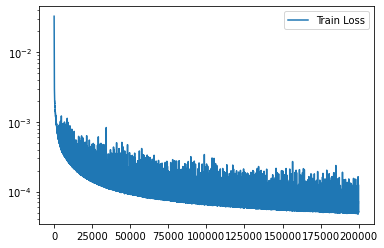

In [4]:
plt.semilogy(loss_history[100:], label="Train Loss")
plt.legend()
plt.show()

In [5]:
# Make some visualizations
model.eval()

# Collect some random points
output = model(None, init_pass=True)

In [6]:
# Visualize 3D Points
predicted = output["points3d"]
gt = mesh_vertices

plotter = pv.Plotter()

predicted = pv.PolyData(predicted.cpu().detach().numpy())
plotter.add_mesh(predicted, color="yellow", render_points_as_spheres=True)

gt = pv.PolyData(mesh_vertices.cpu().detach().numpy())
plotter.add_mesh(gt, color="black", render_points_as_spheres=True)

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [7]:
# Visualize Sphere Mapping
sampled_uv = output["sampled_uv_points"]
inverted_uv = output["inverted_uv_points"]

plotter = pv.Plotter()

sampled = pv.PolyData(sampled_uv.cpu().detach().numpy())
plotter.add_mesh(sampled, color="yellow", point_size=5., render_points_as_spheres=True)

inverted = pv.PolyData(inverted_uv.cpu().detach().numpy())
plotter.add_mesh(inverted, color="black", point_size=5., render_points_as_spheres=True)

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [8]:
# Save the weights

# out_dir = "neutex/pretrained/cat_rescaled_rotated_pretrained_neutex_mapping.pt"
out_dir = "neutex/pretrained/human_pretrained_neutex_mapping.pt"

assert not os.path.exists(out_dir)
torch.save({
    "net_inverse_atlasnet_3d_to_uv": model.net_inverse_atlasnet_3d_to_uv.state_dict(),
    "net_atlasnet_uv_to_3d": model.net_atlasnet_uv_to_3d.state_dict()
}, out_dir)